## Анализ процесса электронно-лучевой сварки
### Выпускная квалификационная работа
по курсу "Аналитик данных" Образовательный центр МГТУ им. Н.Э. Баумана - 2022
<br>
<br><b>Выполнил:</b> <i>Альчаков В.В. гр. AD11872/3<i>

### Подключение необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

# Установить точность вывода - 3 знака после запятой
np.set_printoptions(precision = 3, suppress = True)

# sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error as mae

# scipy
from scipy import stats
from scipy.stats import norm

# Библиотеки для работы с графикой
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Работа с ONNX моделями
import onnx
import tf2onnx
import onnxruntime as rt

# Отключение вывода предупреждений
import warnings
warnings.filterwarnings('ignore')

### Геометрические параметры сварного шва
![alt text](img/welding.png "Title")
<i><b>e</b> - Ширина шва</i><br>
<i><b>q</b> - Выпуклость шва</i><br>
<i><b>h</b> - Глубина провара</i><br>
<i><b>t</b> - Толщина шва</i><br>
<i><b>b</b> - Зазор</i><br>
<i><b>S</b> - Толщина свариваемого металла</i><br>

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию.

### Загрузка исходного датасета
<b>ВХОД:</b>
<ol>
    <li>IW - Ток сварочного тока</li>
    <li>IF - Ток фокусировки электронного пучка</li>
    <li>VW - Скорость сварки</li>
    <li>FP - Расстояние от поверхности образцов</li>
</ol>
<br>
<b>ВЫХОД:</b>
<ol>
    <li>Depth - Глубина шва</li>
    <li>Width - Ширина шва</li>
</ol>

In [2]:
raw_data = pd.read_csv('data/ebw_data.csv')
raw_data.shape

(72, 6)

### Предварительная обработка и разведовательный анализ

##### Просмотр первых строк датасета

In [3]:
raw_data.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


##### Проверка на наличие пропусков

In [4]:
raw_data.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

##### Построение обучающей выборки
Анализ датасета показывает, что комбинации значений столбцов IW, IF, VW, FP повторяются. Поэтому построим новый датасет, с уникальными комбинациями признаков и выходным параметром усредненным по каждой группе

In [5]:
train_data = raw_data.groupby(['IW', 'IF', 'VW', 'FP']).agg({'Depth': ['mean'], 'Width': ['mean']}).reset_index()
train_data.columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']

In [6]:
# Модифицированный датасет для обучения
train_data

,IW,IF,VW,FP,Depth,Width
0,43,146,9.0,60,1.220,1.7650
1,43,150,9.0,50,1.080,1.8150
2,44,146,9.0,60,1.230,1.7950
3,45,140,4.5,80,1.690,2.5100
4,45,140,8.0,80,1.190,1.9700
5,45,141,10.0,80,1.010,1.8600
6,45,146,9.0,60,1.310,1.7600
7,46,141,10.0,80,1.140,1.8200
8,46,146,10.0,60,1.310,1.7700
9,47,134,10.0,110,0.945,1.9350


##### Описательная статистика

In [7]:
train_data.describe()

,IW,IF,VW,FP,Depth,Width
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,45.800000,140.866667,8.866667,80.666667,1.171000,1.957500
std,1.740279,5.462426,2.021904,23.057898,0.229543,0.265678
min,43.000000,131.000000,4.500000,50.000000,0.820000,1.727500
25%,45.000000,139.500000,8.500000,60.000000,1.045000,1.780000
50%,46.000000,141.000000,9.000000,80.000000,1.160000,1.820000
75%,47.000000,146.000000,10.000000,80.000000,1.270000,2.020000
max,49.000000,150.000000,12.000000,125.000000,1.690000,2.515000


##### Расчет корреляционной матрицы
В случае линейной регрессионной модели корреляционная матрица позволит выяснить, какие признаки в большей степени влияют на целевую переменную

In [8]:
# Корреляционная матрица
train_data.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.844566,0.073079,0.831286,-0.389267,0.359959
IF,-0.844566,1.000000,0.066182,-0.983178,0.452146,-0.501293
VW,0.073079,0.066182,1.000000,0.017364,-0.651087,-0.864309
FP,0.831286,-0.983178,0.017364,1.000000,-0.569981,0.432293
Depth,-0.389267,0.452146,-0.651087,-0.569981,1.000000,0.355843
Width,0.359959,-0.501293,-0.864309,0.432293,0.355843,1.000000


##### Корреляционная матрица в виде тепловой карты

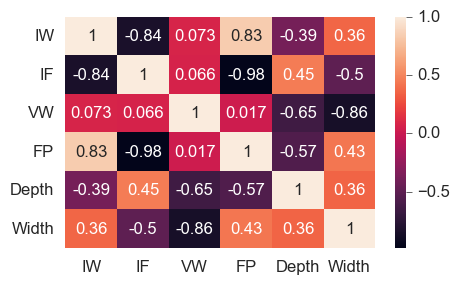

In [9]:
plt.figure(figsize = (5, 3), dpi = 100)
plt.style.use('classic')
sns.set_style('whitegrid')
sns.heatmap(train_data.corr(), annot = True)
plt.show()

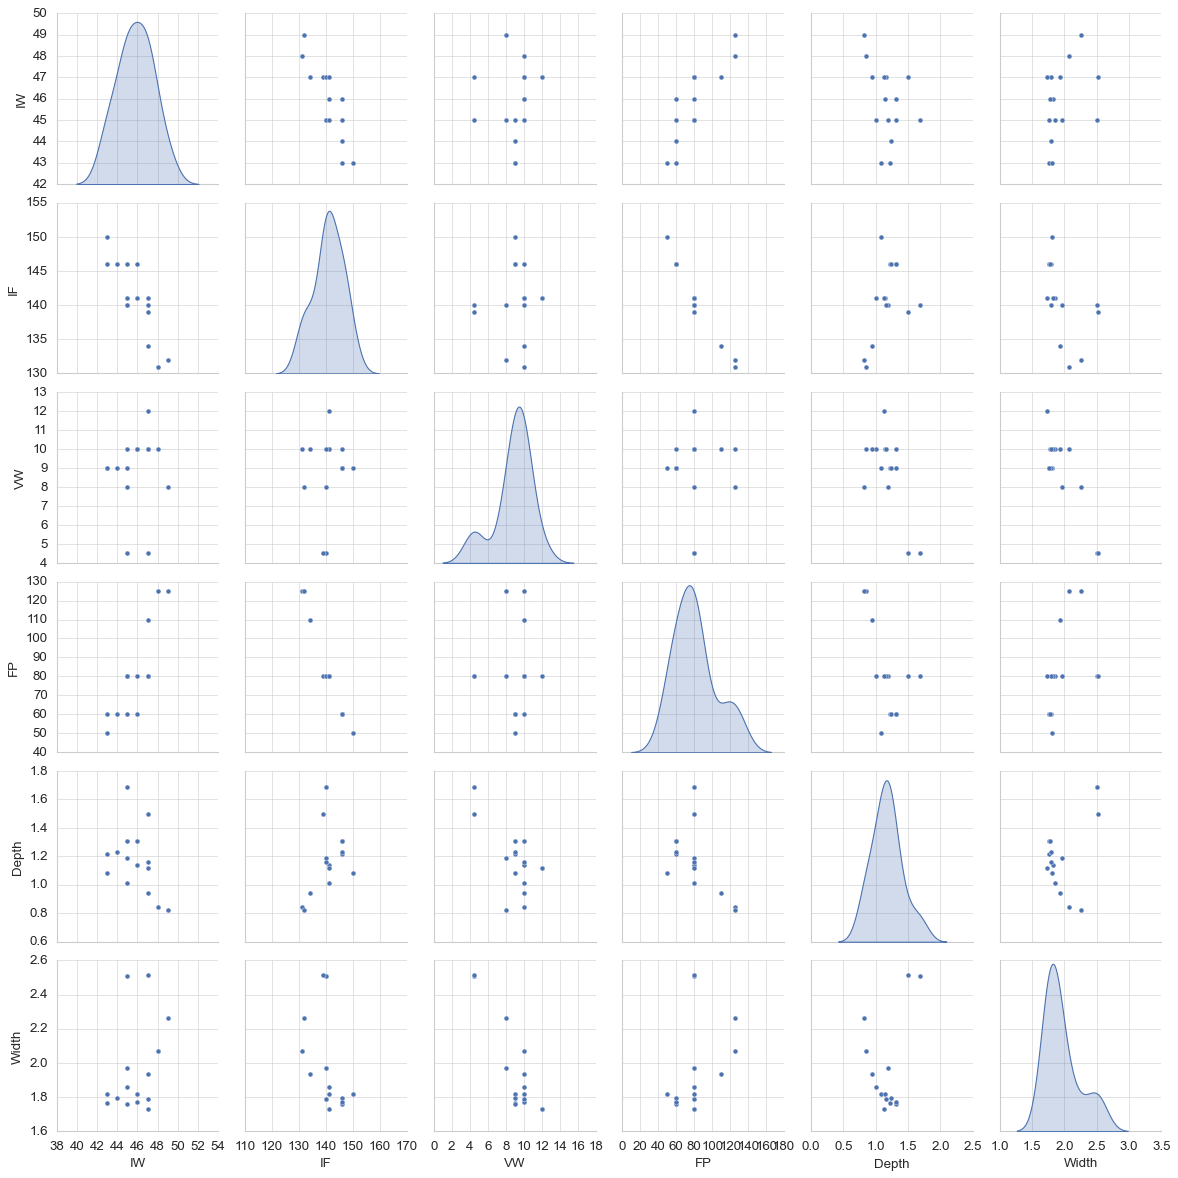

In [10]:
sns.pairplot(train_data[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']], diag_kind = 'kde')

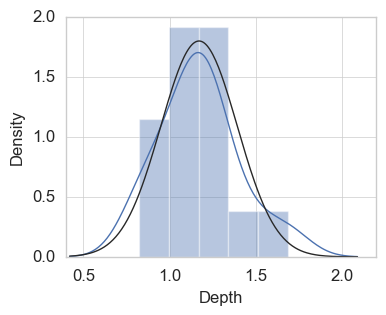

In [11]:
fig = plt.figure(figsize = (4, 3), dpi = 100)
sns.distplot(train_data['Depth'] , fit = norm);

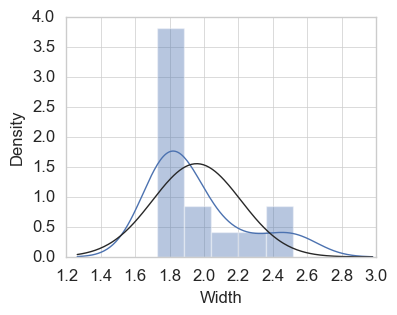

In [12]:
fig = plt.figure(figsize = (4, 3), dpi = 100)
sns.distplot(train_data['Width'] , fit = norm);

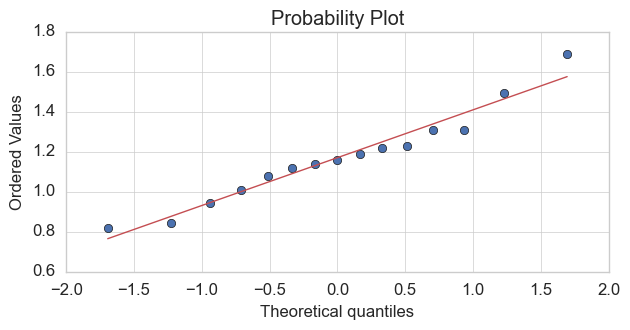

In [13]:
fig = plt.figure(figsize = (7, 3), dpi = 100)
res = stats.probplot(train_data['Depth'], plot = plt)
plt.show()

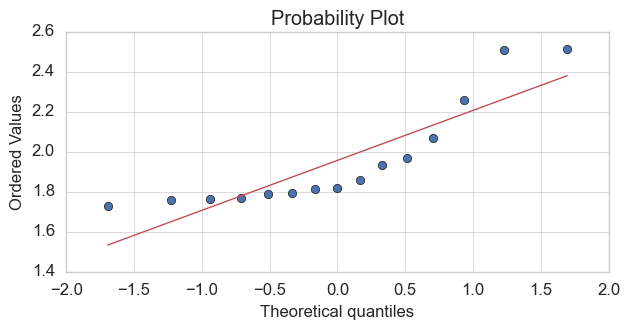

In [14]:
fig = plt.figure(figsize = (7, 3), dpi = 100)
res = stats.probplot(train_data['Width'], plot = plt)
plt.show()

##### Разбиваем выборку на массив признаков и вектор со значениями целевой переменной

In [15]:
# Признаки
X = train_data.drop(['Depth', 'Width'], axis = 1)
# Глубина шва
yD = train_data['Depth']
# Ширина шва
yW = train_data['Width']

In [16]:
# Матрица признаков
X.head()

,IW,IF,VW,FP
0,43,146,9.0,60
1,43,150,9.0,50
2,44,146,9.0,60
3,45,140,4.5,80
4,45,140,8.0,80


In [17]:
# Вектор целевая переменная - Глубина шва
yD.head()

0    1.22
1    1.08
2    1.23
3    1.69
4    1.19
Name: Depth, dtype: float64

In [18]:
# Вектор целевая переменная - Ширина шва
yW.head()

0    1.765
1    1.815
2    1.795
3    2.510
4    1.970
Name: Width, dtype: float64

In [19]:
print('Размерности данных (обучающая выборка)')
print(f'Матрица признаков {X.shape}')
print(f'Целевой вектор (глубина шва) {yD.shape}')
print(f'Целевой вектор (ширина шва) {yW.shape}')

Размерности данных (обучающая выборка)
Матрица признаков (15, 4)
Целевой вектор (глубина шва) (15,)
Целевой вектор (ширина шва) (15,)


##### Разбивка данных на выборки для обучения и тестирования

In [20]:
X_train = pd.DataFrame(train_data.iloc[:, 0:4]).values
yD_train = pd.DataFrame(train_data.iloc[:, 4:5]).values
yW_train = pd.DataFrame(train_data.iloc[:, 5:6]).values

X_test = pd.DataFrame(raw_data.iloc[:, 0:4]).values
yD_test = pd.DataFrame(raw_data.iloc[:, 4:5]).values
yW_test = pd.DataFrame(raw_data.iloc[:, 5:6]).values

In [21]:
# Переменные для хранения точности
test_results_width = {}
test_results_depth = {}

##### Функция отрисовки результатов модели

In [22]:
def plot_model(x, y_test, y_predict, title_txt):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize = (10, 4), dpi = 150)
    plt.plot(x, y_test, 'go-', linewidth = 2, markersize = 5)
    plt.plot(x, y_predict, '-r',  linewidth = 2, alpha = .75)
    plt.legend(['Измерения', 'Предсказания'])
    plt.title(title_txt)
    plt.grid(color = 'b', linestyle = '--', linewidth = 0.5, alpha = .75)
    plt.show()

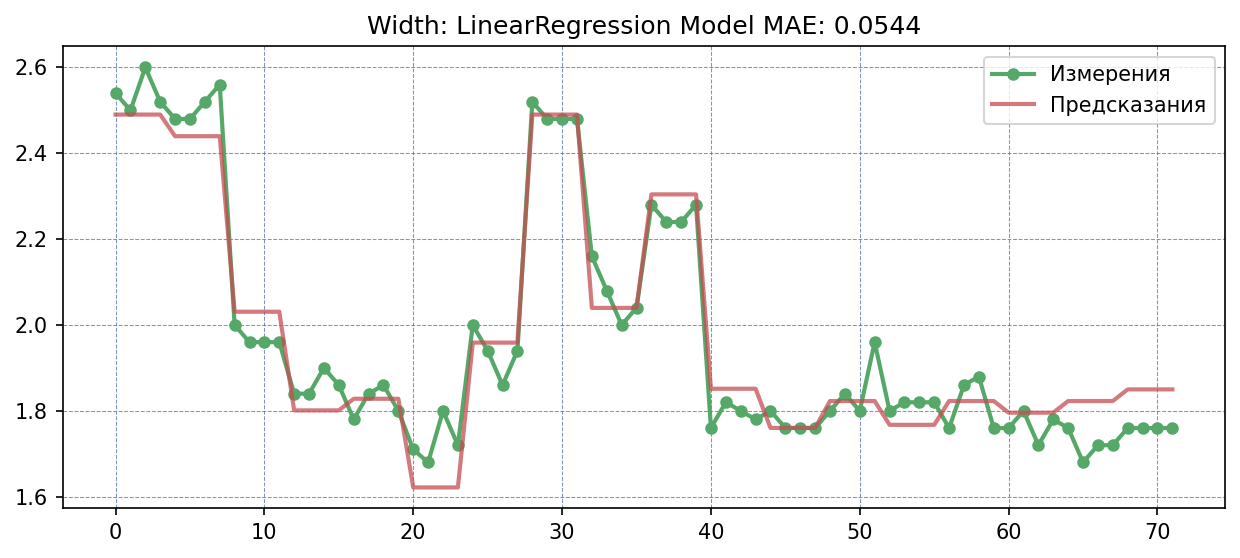

In [23]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, yW_train)
yW_predict = pipe.predict(X_test)
xW_predict = range(yW_predict.shape[0])
test_results_width['LinearRegression'] = mae(yW_test, yW_predict)
plot_model(xW_predict, yW_test, yW_predict, f'Width: LinearRegression Model MAE: {mae(yW_test, yW_predict):0.3}')

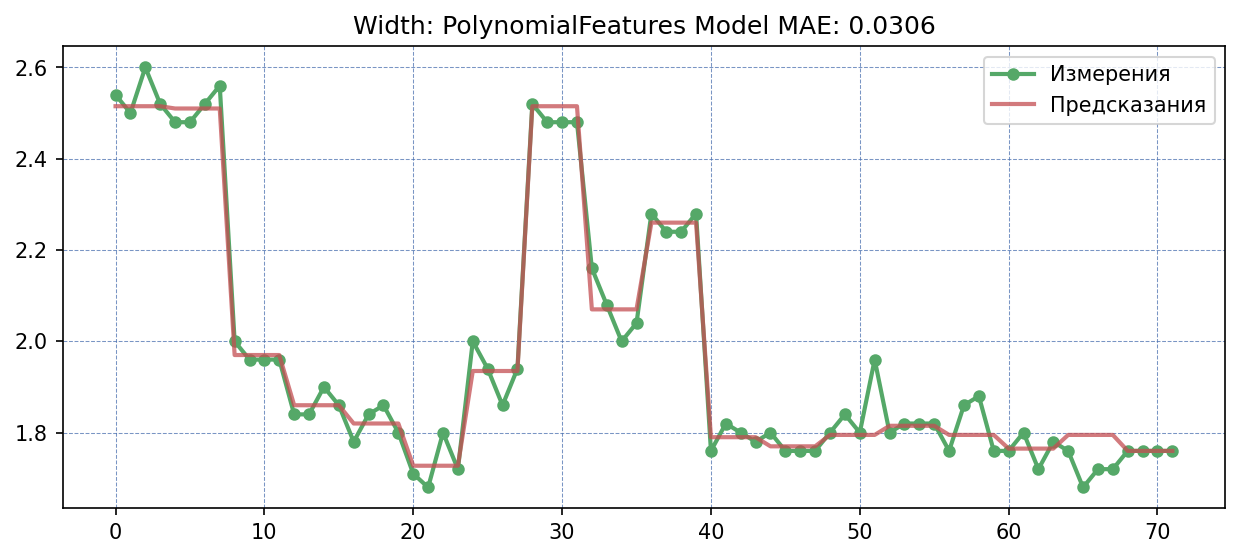

In [24]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
pipe.fit(X_train, yW_train)
yW_predict = pipe.predict(X_test)
xW_predict = range(yW_predict.shape[0])
test_results_width['PolynomialFeatures'] = mae(yW_test, yW_predict)
plot_model(xW_predict, yW_test, yW_predict, f'Width: PolynomialFeatures Model MAE: {mae(yW_test, yW_predict):0.3}')

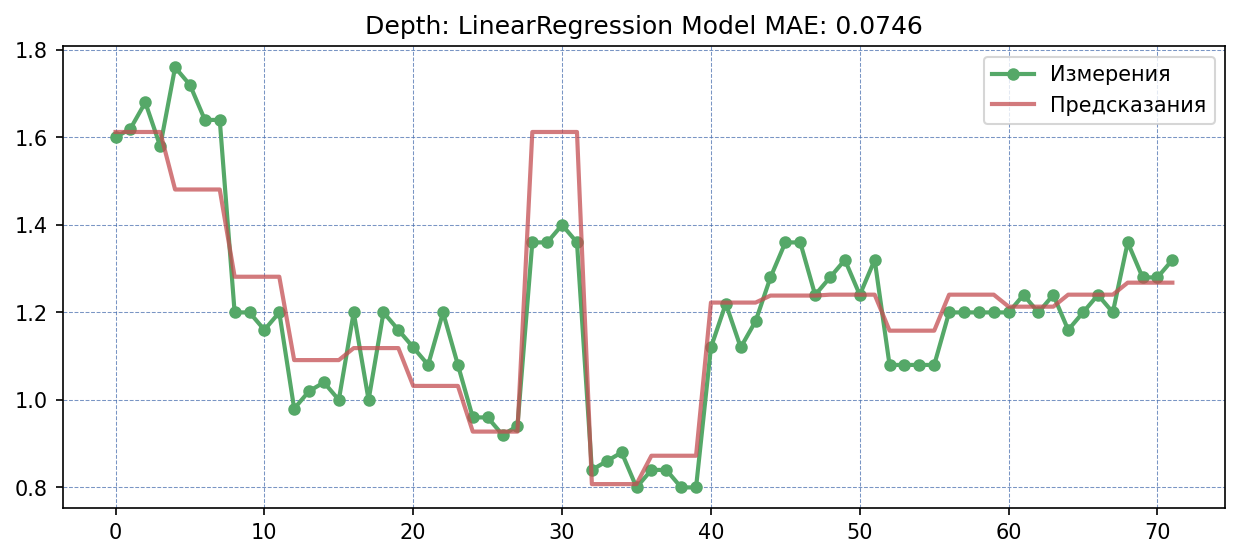

In [25]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, yD_train)
yD_predict = pipe.predict(X_test)
xD_predict = range(yD_predict.shape[0])
test_results_depth['LinearRegression'] = mae(yD_test, yD_predict)
plot_model(xD_predict, yD_test, yD_predict, f'Depth: LinearRegression Model MAE: {mae(yD_test, yD_predict):0.3}')

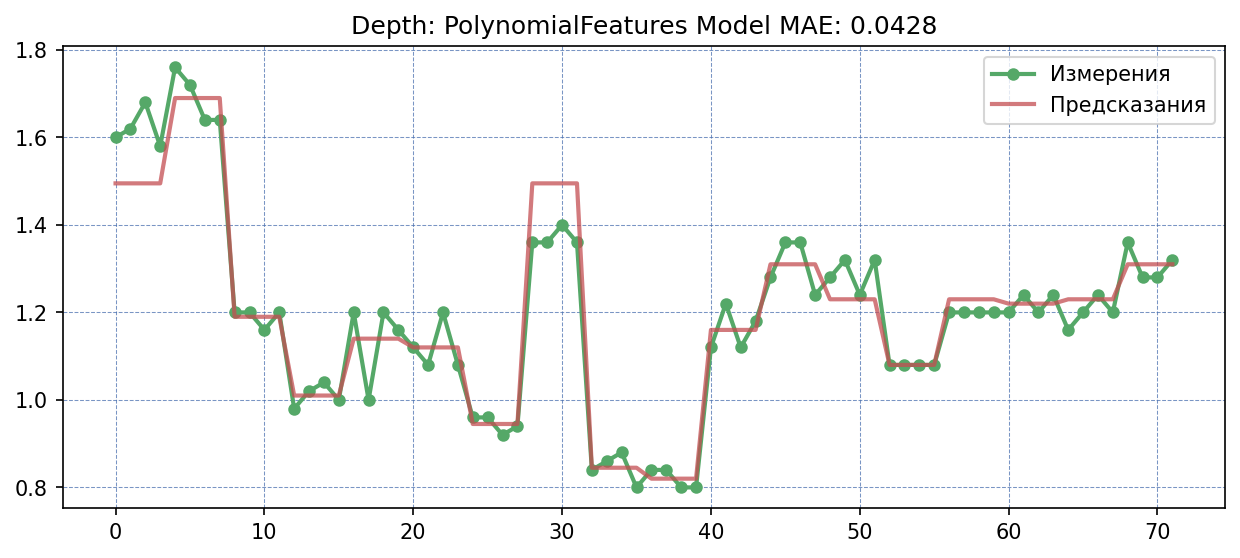

In [26]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
pipe.fit(X_train, yD_train)
yD_predict = pipe.predict(X_test)
xD_predict = range(yD_predict.shape[0])
test_results_depth['PolynomialFeatures'] = mae(yD_test, yD_predict)
plot_model(xD_predict, yD_test, yD_predict, f'Depth: PolynomialFeatures Model MAE: {mae(yD_test, yD_predict):0.3}')

### Применение нейронной сети для анализа

In [27]:
train_features = pd.DataFrame(train_data.iloc[:, 0:4]).values
train_labels = pd.DataFrame(train_data.iloc[:, 4:6]).values
test_features = pd.DataFrame(raw_data.iloc[:, 0:4]).values
test_labels = pd.DataFrame(raw_data.iloc[:, 4:6]).values

In [28]:
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 45.8   140.867   8.867  80.667]]


In [29]:
pd.DataFrame(train_data.iloc[:, 0:4]).describe().T

,count,mean,std,min,25%,50%,75%,max
IW,15.0,45.800000,1.740279,43.0,45.0,46.0,47.0,49.0
IF,15.0,140.866667,5.462426,131.0,139.5,141.0,146.0,150.0
VW,15.0,8.866667,2.021904,4.5,8.5,9.0,10.0,12.0
FP,15.0,80.666667,23.057898,50.0,60.0,80.0,80.0,125.0


In [30]:
seq_model = keras.Sequential([normalizer,
                              layers.Dense(64, activation = 'relu'),
                              layers.Dense(32, activation = 'relu'),
                              layers.Dense(2)
                             ])
seq_model.compile(loss = 'mean_absolute_error', optimizer = tf.keras.optimizers.Adam(0.001), metrics = ['accuracy'])
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,475
Trainable params: 2,466
Non-trainable params: 9
_________________________________________________________________


In [31]:
history = seq_model.fit(train_features, train_labels, epochs = 1000, verbose = 1, validation_split = 0.01)

Epoch 1/1000
1/1 [==============================] - 0s 436ms/step - loss: 1.5638 - accuracy: 0.5714 - val_loss: 1.2055 - val_accuracy: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.5403 - accuracy: 0.5714 - val_loss: 1.1512 - val_accuracy: 0.0000e+00
Epoch 3/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.5175 - accuracy: 0.6429 - val_loss: 1.0972 - val_accuracy: 0.0000e+00
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 1.4949 - accuracy: 0.5714 - val_loss: 1.0444 - val_accuracy: 0.0000e+00
Epoch 5/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.4721 - accuracy: 0.5714 - val_loss: 0.9916 - val_accuracy: 0.0000e+00
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.4492 - accuracy: 0.5000 - val_loss: 0.9398 - val_accuracy: 0.0000e+00
Epoch 7/1000
1/1 [==============================] - 0s 21ms/step - loss: 1.4259 - accuracy: 0.4286 - val_loss: 0.8922 - val_accur

1/1 [==============================] - 0s 21ms/step - loss: 0.3668 - accuracy: 1.0000 - val_loss: 0.8715 - val_accuracy: 1.0000
Epoch 59/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.3617 - accuracy: 1.0000 - val_loss: 0.8431 - val_accuracy: 1.0000
Epoch 60/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.3560 - accuracy: 1.0000 - val_loss: 0.8120 - val_accuracy: 1.0000
Epoch 61/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.3499 - accuracy: 1.0000 - val_loss: 0.7783 - val_accuracy: 1.0000
Epoch 62/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.3436 - accuracy: 1.0000 - val_loss: 0.7439 - val_accuracy: 1.0000
Epoch 63/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.3374 - accuracy: 1.0000 - val_loss: 0.7082 - val_accuracy: 1.0000
Epoch 64/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.3317 - accuracy: 1.0000 - val_loss: 0.6742 - val_accuracy: 1.0000
Epoch 65/1000
1/1 [=

Epoch 116/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.1581 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 1.0000
Epoch 117/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.1558 - accuracy: 1.0000 - val_loss: 0.0912 - val_accuracy: 1.0000
Epoch 118/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1529 - accuracy: 1.0000 - val_loss: 0.0843 - val_accuracy: 1.0000
Epoch 119/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1499 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 1.0000
Epoch 120/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1474 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 1.0000
Epoch 121/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1447 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 1.0000
Epoch 122/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1419 - accuracy: 1.0000 - val_loss: 0.0749 - val_accuracy: 1.0000

1/1 [==============================] - 0s 23ms/step - loss: 0.0398 - accuracy: 1.0000 - val_loss: 0.1363 - val_accuracy: 1.0000
Epoch 174/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0381 - accuracy: 1.0000 - val_loss: 0.1355 - val_accuracy: 1.0000
Epoch 175/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.1331 - val_accuracy: 1.0000
Epoch 176/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.1348 - val_accuracy: 1.0000
Epoch 177/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.1330 - val_accuracy: 1.0000
Epoch 178/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0334 - accuracy: 1.0000 - val_loss: 0.1318 - val_accuracy: 1.0000
Epoch 179/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0336 - accuracy: 1.0000 - val_loss: 0.1312 - val_accuracy: 1.0000
Epoch 180/1000

1/1 [==============================] - 0s 22ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 1.0000
Epoch 231/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.1512 - val_accuracy: 1.0000
Epoch 232/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.1511 - val_accuracy: 1.0000
Epoch 233/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.1492 - val_accuracy: 1.0000
Epoch 234/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.1471 - val_accuracy: 1.0000
Epoch 235/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.1519 - val_accuracy: 1.0000
Epoch 236/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.1597 - val_accuracy: 1.0000
Epoch 237/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1282 - val_accuracy: 1.0000
Epoch 288/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.1251 - val_accuracy: 1.0000
Epoch 289/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.1240 - val_accuracy: 1.0000
Epoch 290/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 1.0000
Epoch 291/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 1.0000
Epoch 292/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.1176 - val_accuracy: 1.0000
Epoch 293/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.1158 - val_accuracy: 1.0000
Epoch 294/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0989 - val_accuracy: 1.0000
Epoch 345/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0983 - val_accuracy: 1.0000
Epoch 346/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0995 - val_accuracy: 1.0000
Epoch 347/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1049 - val_accuracy: 1.0000
Epoch 348/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 1.0000
Epoch 349/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1009 - val_accuracy: 1.0000
Epoch 350/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 1.0000
Epoch 351/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0750 - val_accuracy: 1.0000
Epoch 402/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 1.0000
Epoch 403/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0773 - val_accuracy: 1.0000
Epoch 404/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0732 - val_accuracy: 1.0000
Epoch 405/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0670 - val_accuracy: 1.0000
Epoch 406/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0626 - val_accuracy: 1.0000
Epoch 407/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0599 - val_accuracy: 1.0000
Epoch 408/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0562 - val_accuracy: 1.0000
Epoch 459/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 460/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0518 - val_accuracy: 1.0000
Epoch 461/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 462/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 463/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0560 - val_accuracy: 1.0000
Epoch 464/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 1.0000
Epoch 465/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 1.0000
Epoch 516/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0521 - val_accuracy: 1.0000
Epoch 517/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 518/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 1.0000
Epoch 519/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 1.0000
Epoch 520/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 1.0000
Epoch 521/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 1.0000
Epoch 522/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 573/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 1.0000
Epoch 574/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 1.0000
Epoch 575/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 1.0000
Epoch 576/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0440 - val_accuracy: 1.0000
Epoch 577/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0458 - val_accuracy: 1.0000
Epoch 578/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0463 - val_accuracy: 1.0000
Epoch 579/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 1.0000
Epoch 630/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 1.0000
Epoch 631/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 632/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 633/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 1.0000
Epoch 634/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 1.0000
Epoch 635/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 636/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 1.0000
Epoch 687/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 1.0000
Epoch 688/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 689/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 690/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 1.0000
Epoch 691/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 1.0000
Epoch 692/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0537 - val_accuracy: 1.0000
Epoch 693/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 1.0000
Epoch 744/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 1.0000
Epoch 745/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 1.0000
Epoch 746/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 1.0000
Epoch 747/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 748/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 1.0000
Epoch 749/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 1.0000
Epoch 750/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 1.0000
Epoch 801/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 802/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0400 - val_accuracy: 1.0000
Epoch 803/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 1.0000
Epoch 804/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 805/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 806/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 1.0000
Epoch 807/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 858/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 859/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 1.0000
Epoch 860/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0428 - val_accuracy: 1.0000
Epoch 861/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 1.0000
Epoch 862/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 1.0000
Epoch 863/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0469 - val_accuracy: 1.0000
Epoch 864/1000

1/1 [==============================] - 0s 21ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0402 - val_accuracy: 1.0000
Epoch 915/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 1.0000
Epoch 916/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 1.0000
Epoch 917/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 1.0000
Epoch 918/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 1.0000
Epoch 919/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0429 - val_accuracy: 1.0000
Epoch 920/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 1.0000
Epoch 921/1000

1/1 [==============================] - 0s 20ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 1.0000
Epoch 972/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0404 - val_accuracy: 1.0000
Epoch 973/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 1.0000
Epoch 974/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 1.0000
Epoch 975/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 976/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 1.0000
Epoch 977/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy: 1.0000
Epoch 978/1000

In [32]:
model_score = seq_model.evaluate(test_features, test_labels, verbose = 0)
print(model_score)

[0.038466472178697586, 1.0]


In [33]:
test_predictions = seq_model.predict(test_features)
#print(test_predictions)

3/3 [==============================] - 0s 1000us/step


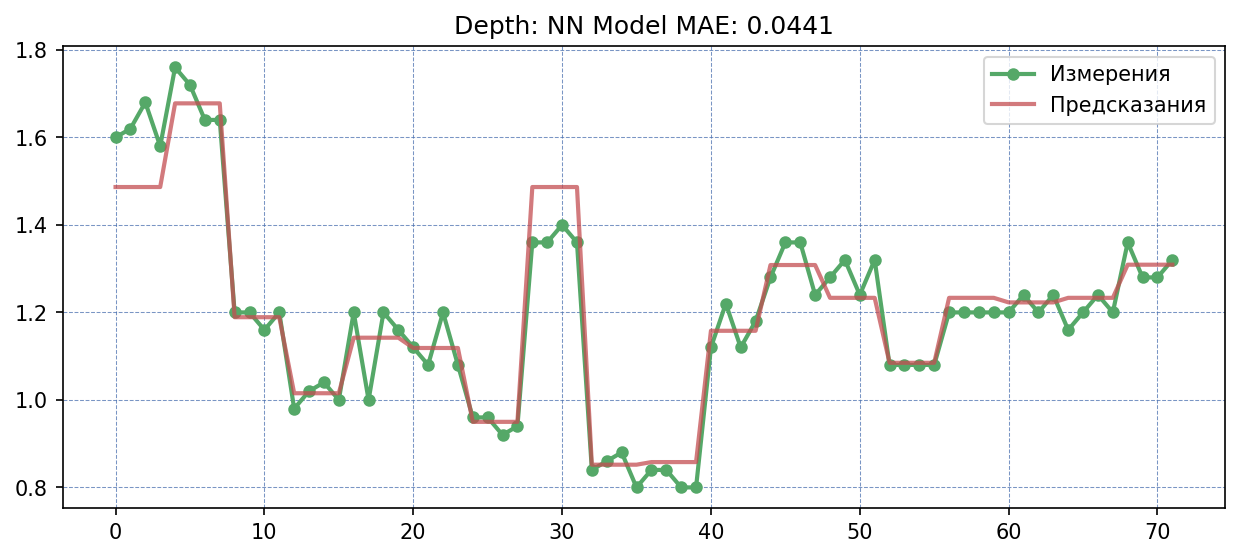

In [34]:
# Анализ Depth
x_predict = range(test_predictions.shape[0])
y_predict = test_predictions[:,:1]
y_test = test_labels[:,:1]
test_results_depth['NN'] = mae(y_test, y_predict)
plot_model(x_predict, y_test, y_predict, f'Depth: NN Model MAE: {mae(y_test, y_predict):0.3}')

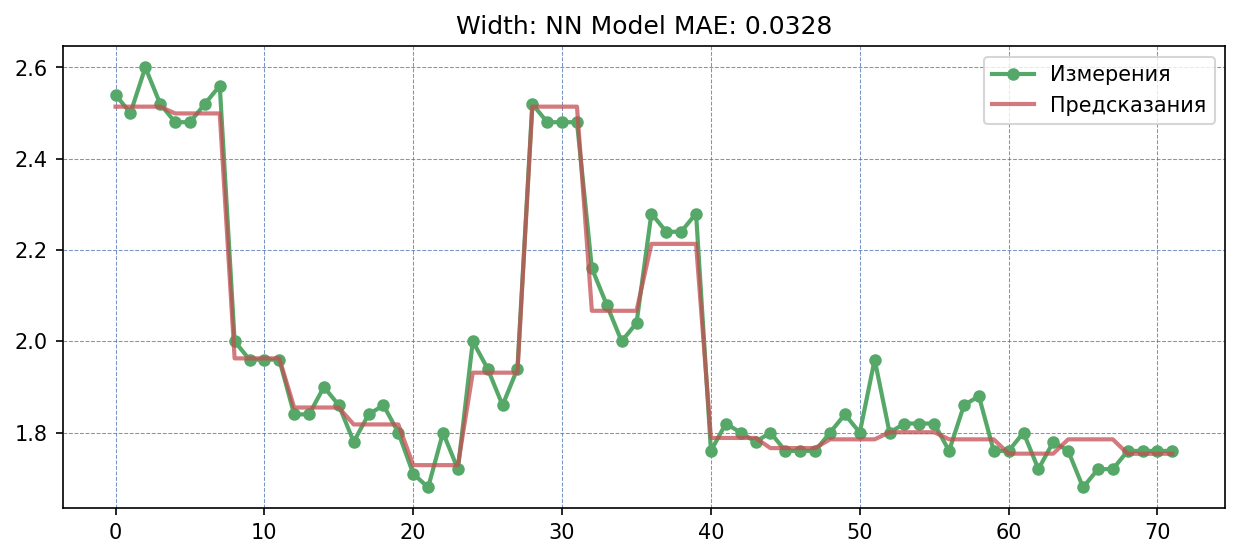

In [35]:
# Анализ Width
x_predict = range(test_predictions.shape[0])
y_predict = test_predictions[:,1:2]
y_test = test_labels[:,1:2]
test_results_width['NN'] = mae(y_test, y_predict)
plot_model(x_predict, y_test, y_predict, f'Width: NN Model MAE: {mae(y_test, y_predict):0.3}')

In [36]:
test_predictions = seq_model.predict(test_features[:1], verbose = 0)
print(f'Параметры: {test_features[:1]}')
print(f'Прогноз: {test_predictions}')
print(f'Истинное значение: {test_labels[:1]}')

Параметры: [[ 47.  139.    4.5  80. ]]
Прогноз: [[1.487 2.514]]
Истинное значение: [[1.6  2.54]]


In [37]:
print("WIDTH")
test_results_width

WIDTH


{'LinearRegression': 0.05442429651267374,
 'PolynomialFeatures': 0.030625000000000013,
 'NN': 0.032834096617168865}

In [38]:
print("DEPTH")
test_results_depth

DEPTH


{'LinearRegression': 0.0745975747744926,
 'PolynomialFeatures': 0.04277777777777795,
 'NN': 0.04409885538948907}

#### Сохранение модели

In [39]:
seq_model.save('model\welding-model')
# Сохранение в формате ONNX
tf2onnx.convert.from_keras(seq_model, output_path = 'model\welding-model.onnx')

INFO:tensorflow:Assets written to: model\welding-model\assets


(ir_version: 7
 producer_name: "tf2onnx"
 producer_version: "1.13.0 2c1db5"
 graph {
   node {
     input: "normalization_input"
     input: "sequential/normalization/sub/y:0"
     output: "sequential/normalization/sub:0"
     name: "sequential/normalization/sub"
     op_type: "Sub"
   }
   node {
     input: "sequential/normalization/sub:0"
     input: "ConstantFolding/sequential/normalization/truediv_recip:0"
     output: "sequential/normalization/truediv:0"
     name: "sequential/normalization/truediv"
     op_type: "Mul"
   }
   node {
     input: "sequential/normalization/truediv:0"
     input: "sequential/dense/MatMul/ReadVariableOp:0"
     output: "sequential/dense/MatMul:0"
     name: "sequential/dense/MatMul"
     op_type: "MatMul"
   }
   node {
     input: "sequential/dense/MatMul:0"
     input: "sequential/dense/BiasAdd/ReadVariableOp:0"
     output: "sequential/dense/BiasAdd:0"
     name: "sequential/dense/BiasAdd"
     op_type: "Add"
   }
   node {
     input: "sequential

#### Загрузка сохраненной модели и тестовый запуск

In [40]:
# Создание переменной сессии для работы с моделью (загрузка модели)
session = rt.InferenceSession('model\welding-model.onnx')
# Создание вектора для параметров
X = np.array([[47.0, 139.0, 4.5, 80.0]], dtype = np.float32)
inputDetails = session.get_inputs()
# Получение прогозна
y = session.run(None, {inputDetails[0].name: X})
print(y)

[array([[1.487, 2.514]], dtype=float32)]
